In [449]:
from tqdm import tqdm
import uproot
import numpy as np
import vector
import awkward as ak

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

In [ ]:
path = "ttbar_100k_dilep_lowlevel.root:Delphes"
tree = uproot.open(path)

jet_pt=tree["Jet/Jet.PT"].array()
jet_eta=tree["Jet/Jet.Eta"].array()
jet_phi=tree["Jet/Jet.Phi"].array()
jet_mass=tree["Jet/Jet.Mass"].array()
track_pt=tree["Track/Track.PT"].array()
track_eta=tree["Track/Track.Eta"].array()
track_phi=tree["Track/Track.Phi"].array()
track_mass=tree["Track/Track.Mass"].array()


In [ ]:
btagged_jets = tree["Jet/Jet.BTag"].array()
at_least_two_btag_recon_mask = (np.sum(btagged_jets, axis=1) > 1)
jet_vector = vector.zip({'pt': jet_pt, 'eta': jet_eta, 'phi': jet_phi, 'm': jet_mass})[btagged_jets==1][at_least_two_btag_recon_mask]
track_vector = vector.zip({'pt': track_pt, 'eta': track_eta, 'phi': track_phi, 'm': track_mass})[at_least_two_btag_recon_mask]

In [ ]:
#this has been saved in the text file corresponding_jet
def match_jets_to_tracks(jet_vector, track_vector, threshold=0.4):
    matched_indices = []
    for event_jets, event_tracks in tqdm(zip(jet_vector, track_vector)):
        mins = [jet.deltaR(event_tracks) for jet in event_jets]
        matched_indices.append((np.min(mins, axis = 0)<threshold) * (np.argmin(mins, axis=0)+1))
    




    return ak.Array(matched_indices)

In [ ]:
corresponding_jet = match_jets_to_tracks(jet_vector,track_vector)

In [ ]:
tracks_in_jet_1 = track_vector[corresponding_jet==1]
tracks_in_jet_2 = track_vector[corresponding_jet==2]
tracks_in_jet_3 = track_vector[corresponding_jet==3]



In [376]:
jet_vector

<MomentumArray4D [[{rho: 104, phi: ..., ...}, ...], ...] type='29752 * var ...'>

In [604]:
def pull(jet, tracks):
    pt_track = tracks.pt
    r = (jet.deltaRapidityPhi(tracks))
    pt_jet = jet.pt
    delta_y = jet.rapidity - tracks.rapidity
    delta_phi = jet.deltaphi(tracks)
    pull_y = ((pt_track * r) / pt_jet) * delta_y
    pull_phi = ((pt_track * r) / pt_jet) * delta_phi
    x= vector.zip({'x': pull_y, 'y': pull_phi})
    return np.sum(x, axis=1)

#x: rapidity and y: phi
pull_jet_1= pull(jet_vector[:,0], tracks_in_jet_1)
pull_jet_2 = pull(jet_vector[:,1], tracks_in_jet_2)


In [619]:
pull_jet_1[200]

<VectorRecord2D {x: -0.000223, y: 0.000905} type='Vector2D[x: float32, y: f...'>

0.3549948

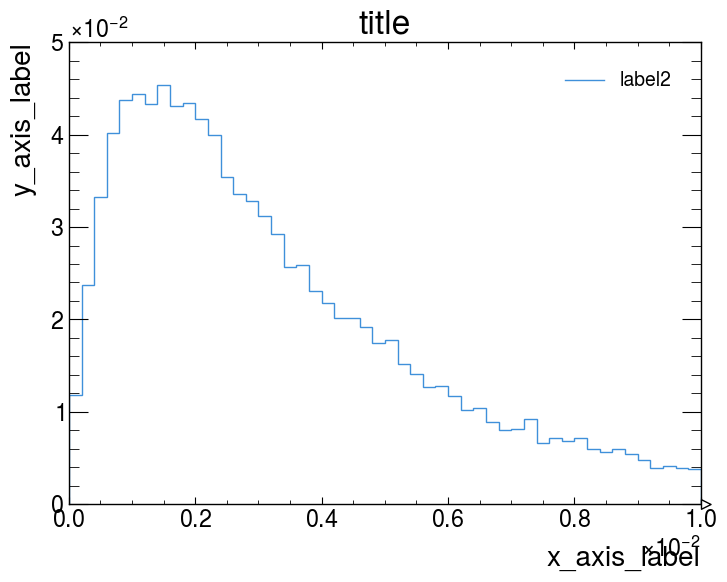

In [561]:
import uproot
import vector
import boost_histogram as bh
import numpy as np
import mplhep as hep
import matplotlib.pyplot as plt
import awkward as ak
import matplotlib as mpl
import pandas as pd
hep.style.use(hep.style.ATLAS)
hist1 = bh.Histogram(bh.axis.Regular(50, 0, 0.01))  
hist1.fill(np.abs(pull_jet_1)) 
hist1 /= hist1.sum()
hep.histplot(hist1, label = "label2")
plt.title("title")
plt.xlabel("x_axis_label")
plt.ylabel("y_axis_label")
plt.legend()
plt.show()

In [568]:
pull_jet_1.x

<Array [0.00229, -0.00741, ..., 0.00219, -0.00073] type='29752 * float32'>

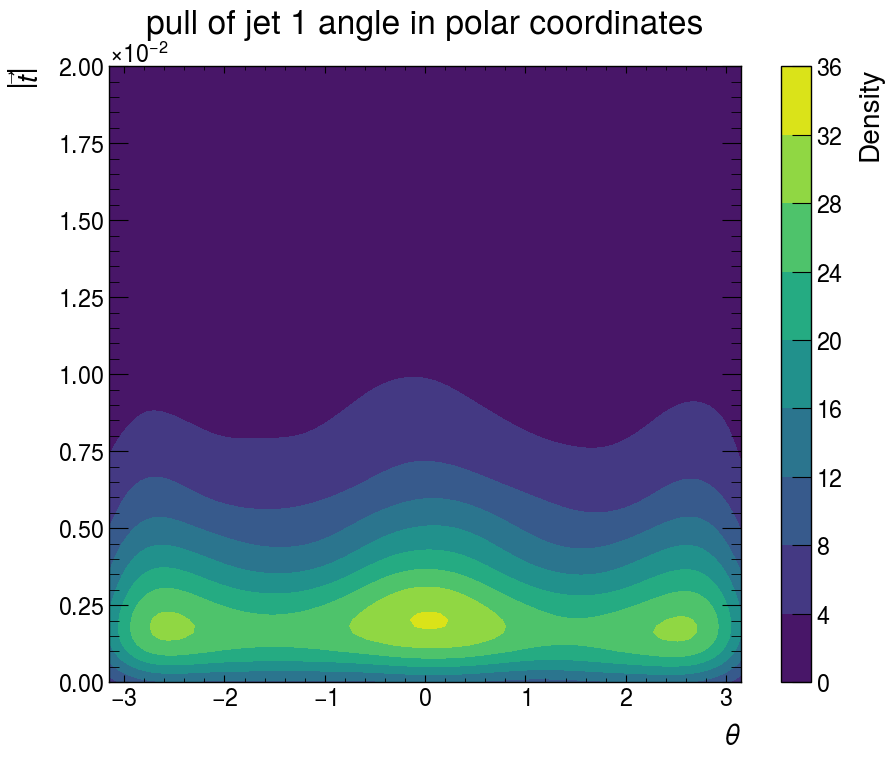

In [580]:
delta_pull_two_jets = pull_jet_1-pull_jet_2
mag_delta_pull_two_jets = np.abs(delta_pull_two_jets)


from scipy.interpolate import griddata
x = np.arctan2(pull_jet_1.x,pull_jet_1.y)
xy = np.vstack([x, np.abs(pull_jet_1)])
kde = gaussian_kde(xy)
xmin, xmax = -3.15, 3.15
ymin, ymax = 0, 0.02

# Create a grid over the range of the data
theta_grid = np.linspace(xmin, xmax, 100)
pull_grid = np.linspace(ymin, ymax, 100)
theta_mesh, pull_mesh = np.meshgrid(theta_grid, pull_grid)

# Evaluate KDE on the grid points
z_values = kde(np.vstack([theta_mesh.ravel(), pull_mesh.ravel()])).reshape(theta_mesh.shape)

# Plot the heatmap
plt.figure(figsize=(10, 8))
plt.contourf(theta_mesh, pull_mesh, z_values, levels=8, cmap='viridis')
plt.colorbar(label='Density')
plt.xlabel(r'$\theta$')
plt.ylabel(r'$\left| \vec{t} \right|$')
plt.title('pull of jet 1 angle in polar coordinates')
plt.show()



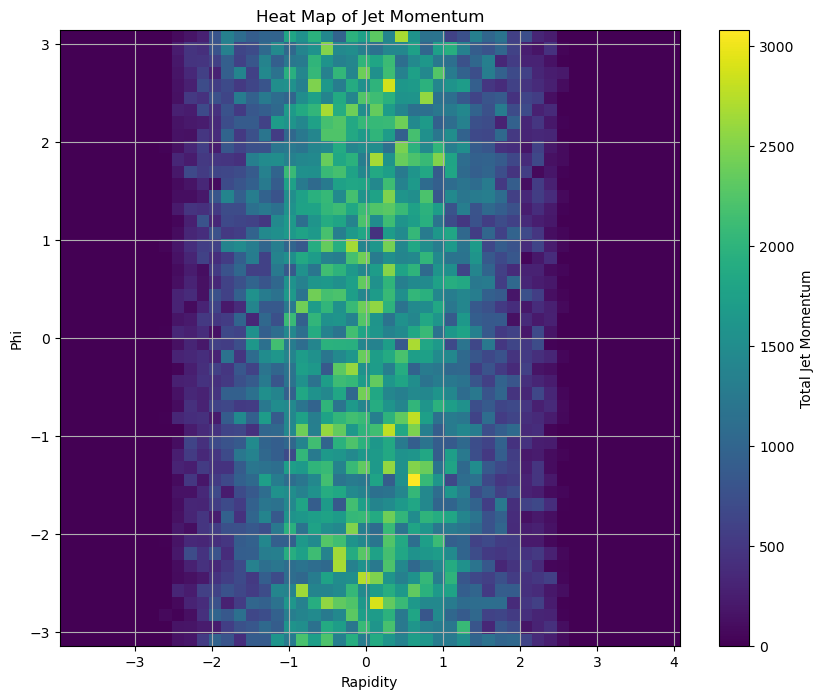

In [548]:
import numpy as np
import matplotlib.pyplot as plt

# Example data (replace with your actual data)
momentum = np.sum(tracks_in_jet_1.pt, axis=1)  # Replace with actual momentum data
rapidity = np.array(jet_vector[:, 0].rapidity)  # Replace with actual rapidity data
phi = np.array(jet_vector[:, 0].phi)  # Replace with actual phi data

# Define the number of bins for the 2D histogram
num_bins = 50

# Create a 2D histogram where each bin will sum the momentum values
hist, xedges, yedges = np.histogram2d(rapidity, phi, bins=num_bins, weights=momentum)

if isinstance(hist, ak.highlevel.Array):
    hist = hist.to_list()  # Convert to a Python list
    hist = np.array(hist) 

# Plot the heatmap
plt.figure(figsize=(10, 8))
plt.imshow(hist.T, origin='lower', cmap='viridis', extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], aspect='auto')
plt.colorbar(label='Total Jet Momentum')
plt.xlabel('Rapidity')
plt.ylabel('Phi')
plt.title('Heat Map of Jet Momentum')
plt.grid(True)
plt.show()